# Example 1 - DIC-C2DH-HeL

Trains a graph neural network to trace cells using DIC-C2DH-HeL dataset. 

## 1. Setup
Imports and defines the objects needed for this example.

In [320]:
import numpy as np
import matplotlib.pyplot as plt

import graphtrack as gt
from graphtrack import deeptrack as dt

import tensorflow as tf

import logging
logging.disable(logging.WARNING) 

## 2. Create data generator

We create a data generator by calling the function `GraphGenerator()`. Notice we also provide augmentations to be applied to the sequence. 

The data generator returns the graph information comprising the node features, edge features, connection matrix, and edge weights. Since `output_type = "edges"`, the labels contain only the edge targets. 

In [624]:
# Name of the dataset
DATASET = "DIC-C2DH-HeLa"

# Augmentation parameters
augmentation_list = {
    "FlipLR": {},
    "FlipUD": {},
    "FlipDiagonal": {},
}

# Seach radius for the graph edges
radius = 0.2
#radius = 120/512

# Output type
_OUTPUT_TYPE = "edges"

generator = gt.GraphGenerator(
    dataset=DATASET,
    radius=radius,
    min_data_size=256,
    max_data_size=257,
    min_sequence_length=10,
    max_sequence_length=15,
    batch_size=8,
    augmentation=augmentation_list,
    output_type=_OUTPUT_TYPE,
    rare_event_weight=50,
)

With  FlipLR
With  FlipUD
With  FlipDiagonal


## 3. Define the neural network model

The neural network architecture used is a message passing graph neural network, with attention layers as update functions. We create this model by calling the function `mpGraphNet()`.

In [625]:
model = gt.gnns.mpGraphNet(
    dense_layer_dimensions=(32, 64, 96),   # number of features in each dense encoder layer
    base_layer_dimensions=(96, 96),        # Latent dimension throughout the message passing layers
    number_of_node_features=7,             # Number of node features in the graphs
    number_of_edge_features=1,             # Number of edge features in the graphs
    number_of_outputs=2,                   # Number of predicted features
    output_activation=None,                # Activation function for the output layer
    output_type=_OUTPUT_TYPE,              # Output type. Either "edges", "nodes", or "graph"
)

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

#model.model.summary()

## 4. Training the network

We train the network for 100 epochs, using a continuous graph generator.

In [626]:
with generator:
    model.fit(generator, epochs=100)

Generating 256 / 256 samples before starting training
Epoch 1/100
32/32 [==============================] - 2s 58ms/step - loss: 0.7361 - accuracy: 0.6737
Epoch 2/100
32/32 [==============================] - 2s 73ms/step - loss: 0.2107 - accuracy: 0.9193
Epoch 3/100
32/32 [==============================] - 2s 48ms/step - loss: 0.0368 - accuracy: 0.9933
Epoch 4/100
32/32 [==============================] - 1s 31ms/step - loss: 0.0236 - accuracy: 0.9943
Epoch 5/100
32/32 [==============================] - 2s 47ms/step - loss: 0.0207 - accuracy: 0.9947
Epoch 6/100
32/32 [==============================] - 2s 65ms/step - loss: 0.0176 - accuracy: 0.9950
Epoch 7/100
32/32 [==============================] - 2s 53ms/step - loss: 0.0179 - accuracy: 0.9949
Epoch 8/100
32/32 [==============================] - 1s 32ms/step - loss: 0.0177 - accuracy: 0.9948
Epoch 9/100
32/32 [==============================] - 1s 40ms/step - loss: 0.0150 - accuracy: 0.9956
Epoch 10/100
32/32 [==========================

## 4. Evaluate Model

In [641]:
import graphtrack as gt
images, val_data, val_labels = gt.GetValidationSet(size=3)

In [642]:
v = [
    np.expand_dims(val_data[0][0][:,1:], 0),
    np.expand_dims(val_data[1][0], 0),
    np.expand_dims(val_data[2][0][:,2:], 0),
    np.expand_dims(val_data[3][0], 0)
]
output_edge_f = model.predict(v)

g = np.argmax(val_labels[1][0], axis=-1)
p = np.argmax(output_edge_f[0], axis=1)

from sklearn.metrics import accuracy_score

print("accuracy: " + str(accuracy_score(g, p)))

accuracy: 1.0


In [657]:
nodes = val_data[0][0]
edges = val_data[2][0]
groundt = np.argmax(val_labels[1][0], axis=1)

edges = np.concatenate((
    edges,
    np.expand_dims(groundt,axis=-1), 
    np.expand_dims(p,axis=-1)),
    axis=-1
)

cell_images = images[0][0]

In [644]:
attention_weights = [v.numpy() for v in model.variables if "attention_weights" in v.name]
attention_weights = np.concatenate(attention_weights, axis=0)
attention_weights = attention_weights.mean(axis=1)
attention_weights = attention_weights.mean(axis=0)

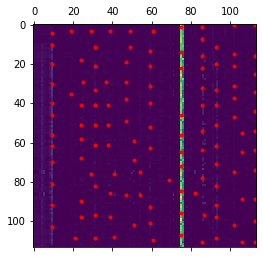

In [662]:
from skimage.feature import peak_local_max

plt.matshow(attention_weights)
coordinates = peak_local_max(attention_weights, min_distance=5, exclude_border=False)

plt.plot(coordinates[:, 1], coordinates[:, 0], 'r.')

In [658]:
# ididxs = np.unique(max_index_row)
idxs = np.unique(coordinates[:, 1])

In [659]:
th = 0.1

values = np.sum(attention_weights[:, idxs], axis=0)
values = values/np.max(values)

sortidx = np.argsort(-values)
values = values[sortidx]
idxs = idxs[sortidx]

idxs = idxs[values> th]
values = values[values> th]

In [660]:
from skimage.morphology import disk, dilation
from scipy.ndimage import gaussian_filter

att = np.zeros(image.shape)
coord = (nodes[idxs, 1:3] * cell_images.shape[0]).astype(np.int)

att[coord[:,0], coord[:,1]] = values
att = dilation(att, disk(20, dtype=bool))
att = gaussian_filter(att, sigma=20)


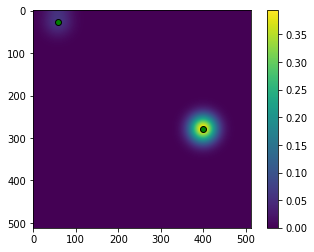

In [661]:
plt.imshow(att)
plt.colorbar()

# plot nodes
plt.scatter(
    nodes[idxs, 2] * np.shape(image)[0],
    nodes[idxs, 1] * np.shape(image)[1], 
    color='g', 
    edgecolors="k", 
    zorder = 3
)

In [655]:
nodes[idxs,:]

array([[7.        , 0.54484388, 0.78045609, 0.26545   , 0.95827064,
        0.3548833 , 0.72239209, 0.97502296],
       [0.        , 0.05468585, 0.11428653, 0.23635   , 0.89331127,
        0.34051145, 0.65596845, 0.98725982]])

0


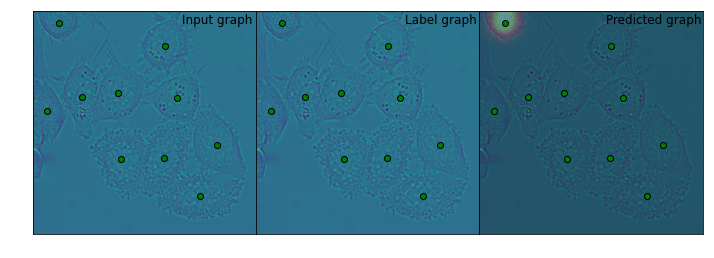

1


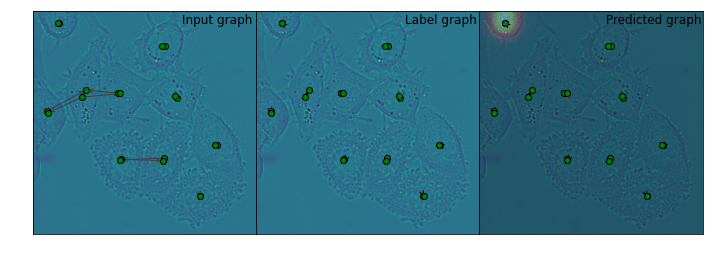

2


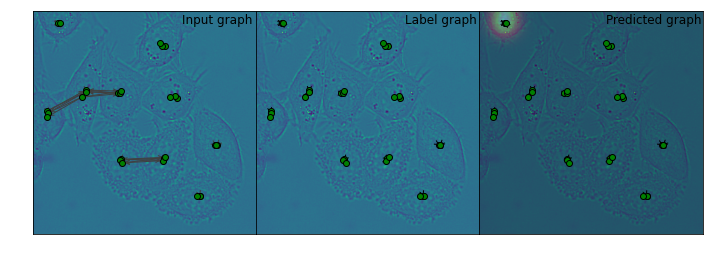

3


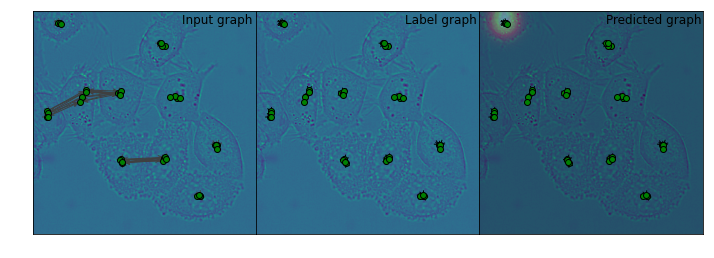

4


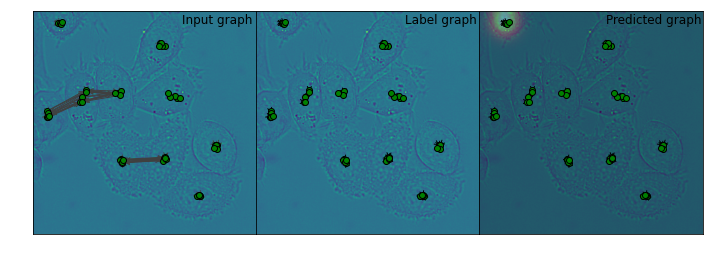

5


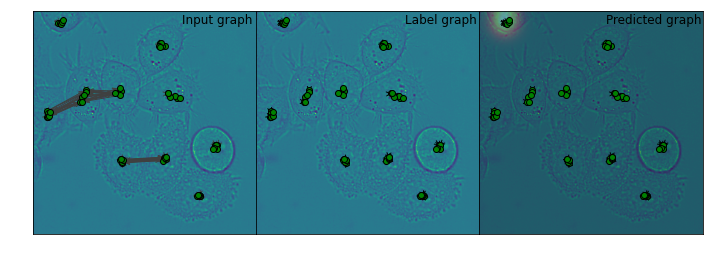

6


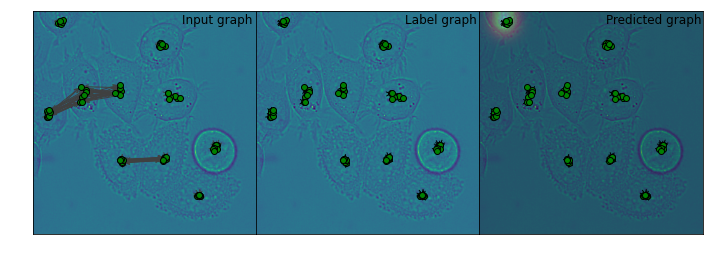

7


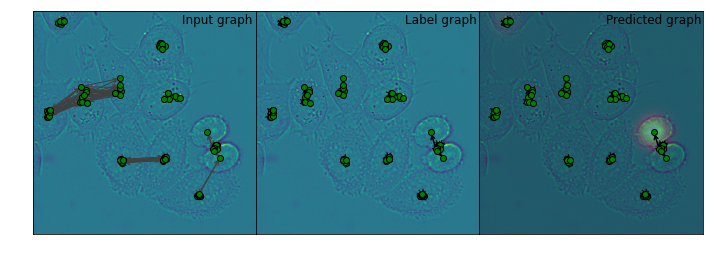

8


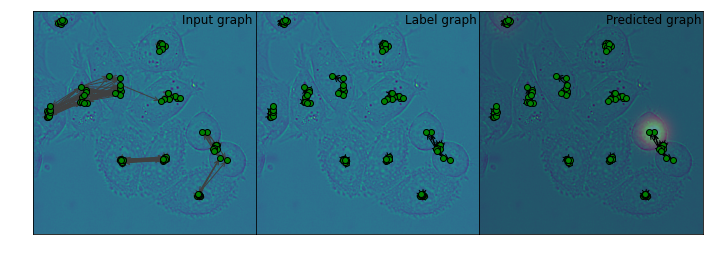

9


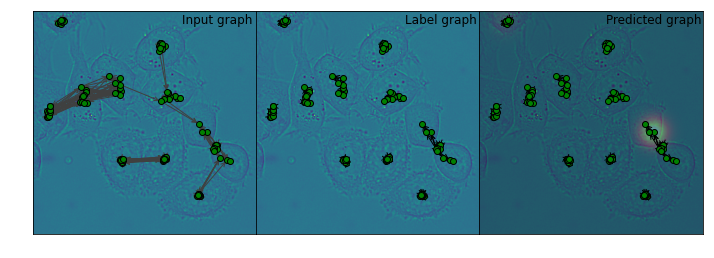

In [656]:
import matplotlib as mpl
import numpy as np

from skimage.morphology import disk, dilation
from scipy.ndimage import gaussian_filter


head = 0
att_points = nodes[idxs,:]

# Draw edges
max_frame = np.max(nodes[:,0]).astype(np.int32)

for frame in range(max_frame):
    fig, axs = plt.subplots(1,3, figsize=(12,24))

    frame_nodes = nodes[nodes[:,0] <= frame,:]

    image = cell_images[...,frame]
    axs[0].imshow(image)
    axs[0].text(340, 30, "Input graph", fontsize = 12,
           color = 'k')

    axs[1].imshow(image)
    axs[1].text(340, 30, "Label graph", fontsize = 12,
           color = 'k')

    axs[2].imshow(image)
    axs[2].text(290, 30, "Predicted graph", fontsize = 12,
           color = 'k')

    _att_points = att_points[att_points[:,0] <= frame,:]
    att = np.zeros(image.shape)
    coord = (_att_points[:, 1:3] * image.shape[0]).astype(np.int)

    values = np.sum(attention_weights[:, idxs], axis=0)
    values = values/np.max(values)

    if np.any(coord):
        att[coord[:,0], coord[:,1]] = values[:len(coord)]
        att = dilation(att, disk(20, dtype=bool))
        att = gaussian_filter(att, sigma=20)

        plt.imshow(att, cmap="hot", alpha=.25, interpolation='bilinear')

    # plot nodes
    axs[0].scatter(
        frame_nodes[:, 2] * np.shape(image)[0],
        frame_nodes[:, 1] * np.shape(image)[1], 
        color='g', 
        edgecolors="k", 
        zorder = 3
    )
    axs[0].tick_params(             
        bottom=False,  
        left=False,
        labelcolor="none"
    ) 

    # plot nodes
    axs[1].scatter(
        frame_nodes[:, 2] * np.shape(image)[0],
        frame_nodes[:, 1] * np.shape(image)[1], 
        color='g', 
        edgecolors="k", 
        zorder = 3
    )
    axs[1].tick_params(             
        bottom=False,  
        left=False,
        labelcolor="none"
    )

    # plot nodes
    axs[2].scatter(
        frame_nodes[:, 2] * np.shape(image)[0],
        frame_nodes[:, 1] * np.shape(image)[1], 
        color='g', 
        edgecolors="k", 
        zorder = 3
    )
    axs[2].tick_params(             
        bottom=False,  
        left=False,
        labelcolor="none"
    )  

    frame_edges = edges[edges[:,1] <= frame]
    print(frame)
    for edge in frame_edges:
        arrow = mpl.patches.FancyArrowPatch(
            posA=np.flip(nodes[edge[2],1:3]) * np.shape(image)[0],
            posB=np.flip(nodes[edge[3],1:3]) * np.shape(image)[1],
            arrowstyle='->', mutation_scale=10, color = '0.25', zorder = 2
        )
        axs[0].add_patch(arrow) 
    
        if edge[4]:
            arrow = mpl.patches.FancyArrowPatch(
                posA=np.flip(nodes[edge[2],1:3]) * np.shape(image)[0],
                posB=np.flip(nodes[edge[3],1:3]) * np.shape(image)[1],
                arrowstyle='->', mutation_scale=10, color = '0', zorder = 2
            )
            axs[1].add_patch(arrow) 
        
        if edge[-1]:
            arrow = mpl.patches.FancyArrowPatch(
                posA=np.flip(nodes[edge[2],1:3]) * np.shape(image)[0],
                posB=np.flip(nodes[edge[3],1:3]) * np.shape(image)[1],
                arrowstyle='->', mutation_scale=10, color = '0', zorder = 2
            )
            axs[2].add_patch(arrow) 

    axs[0].set_aspect('equal', 'box')

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.savefig(f"videos/{frame}.png", bbox_inches='tight')
    plt.show()

In [379]:
import imageio
import glob
import os

remove = False

frames = glob.glob("videos/*.png")
images = [imageio.imread(frame) for frame in frames]
imageio.mimwrite("videos/movie.mp4", images, fps=1)

if remove:
    _ = [os.remove(frame) for frame in frames]